# **Final Notebook for the 2023 Code 600 Intern Final Presentations**

This notebook will serve to show all of the code written to produce the plots in Lasata Tuladhar's final presentation for Code 600 interns at NASA Goddard Space Flight Center (GSFC) in Greenbelt, Maryland. This presentation was given in-person and simultaneously broadcasted on Microsoft Teams on Tuesday, August 8th, 2023 @ 2:30 PM. 

## **Candidate:** KOI-984 (KIC 1161345)

KOI-984 is a warm Jupiter system with two confirmed planets, one of which is a transiting planet. The target star has a companion that is 1.7 arcseconds away that could be influencing the original signal. This project originally aimed to re-check the algorithm that identified transiting exoplanets to avoid biases and remove contamination. However, after observing the KOI-984 system, a new goal of analyzing KOI-984 specifically to determine the relationship with its companion arose. More information and parameters on KOI-984 can be found here: https://exoplanetarchive.ipac.caltech.edu/overview/KOI-984 and here: http://www.exoplanetkyoto.org/exohtml/KOI-984.html. A more interactive model of the KOI-984 system can be found here: https://exoplanets.nasa.gov/exoplanet-catalog/8530/koi-984-c/. A paper that conducted a similar analysis on the same system can be found here: https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.4604S/abstract.

### **Step 1:** Import all necessary libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lightkurve as lk
from tqdm.notebook import tqdm

from astropy.coordinates import SkyCoord
import astropy.units as u

from lightkurve.prf.tpfmodel import StarPrior, GaussianPrior, UniformPrior, StarParameters
from lightkurve.prf.prfmodel import KeplerPRF, SimpleKeplerPRF

from scipy.optimize import minimize

/Users/maniktuladhar/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### **Step 2:** Call the candidate data avaliable in the _lightkurve_ package. Then, download and plot a single light curve from a specified _Kepler_ Quarter.

For the purposes of this project, _Kepler_ Quarters 5 and 7 (Quarter 5 is used until stated otherwise) will be used as the example. However, all of these processes have been properly implemented on all of the _Kepler_ Quarters, 0-17. 

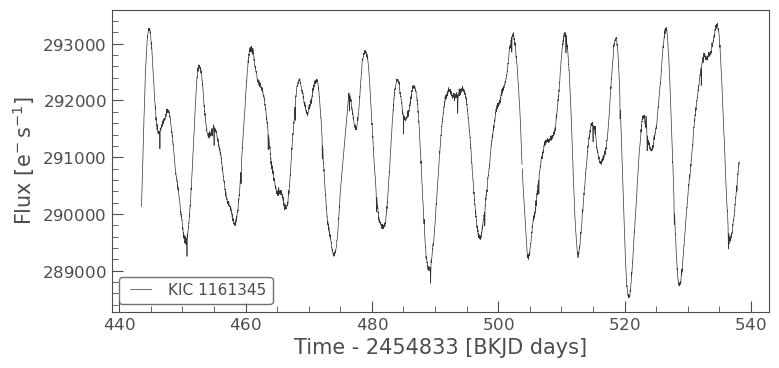

In [4]:
search_result = lk.search_lightcurve('KIC 1161345', author='Kepler') # KIC 1161345 is how KOI-984 is classified in the Kepler database.
lc = search_result[5].download()
lc.plot()

### **Step 3:** Search for a single target pixel file (TPF) for the target. Then, download and plot the TPF.

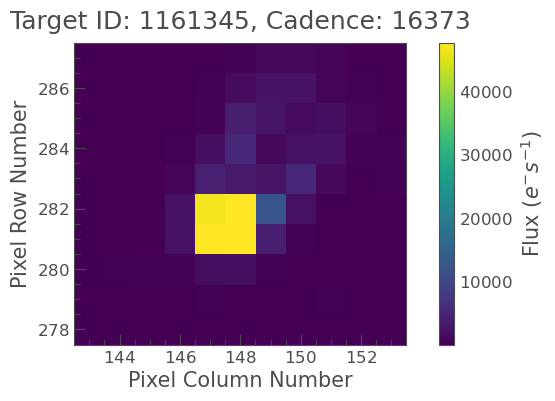

In [5]:
search_result2 = lk.search_targetpixelfile('KOI-984', exptime=1800)
tpf5 = search_result2[5].download()
tpf5.plot()

This TPF is not included in the final presentation. This plot is included in this notebook for completeness and clarity.

### **Step 4:** Convert the TPF into a light curve.

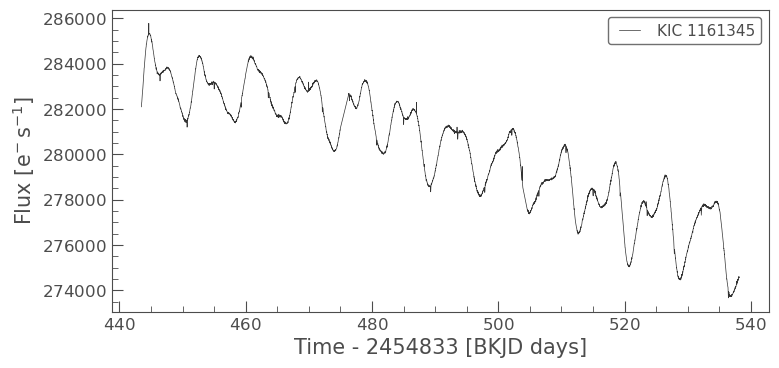

In [6]:
lc2 = tpf5.to_lightcurve()
lc2.plot()

This light curve created from the TPF is not included in the final presentation. This plot is included in this notebook for completeness and clarity. 

### **Step 5:** Create the same light curve as seen in **Step 2**, but stitch the data together.

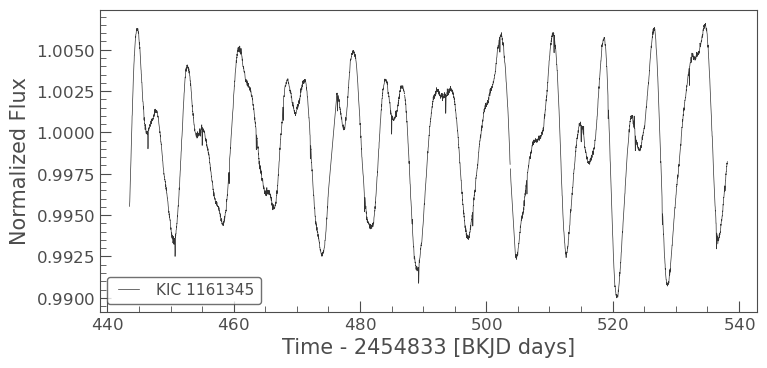

In [7]:
sr5 = lk.search_lightcurve('KIC 1161345', author='Kepler', quarter = 5)
lc5 = sr5.download_all().stitch() # We must to use .stitch() even when looking at one Quarter, otherwise it will give an error.
lc5.plot();

### **Step 6:** Convert the above light curve into a periodogram and estimate the period at maximum power.

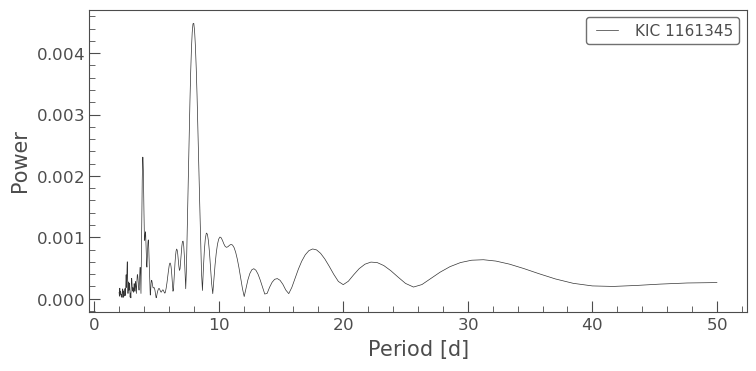

In [8]:
f = np.arange(0.02, 0.5, 0.001) # We must include this step in order for the plots to be correct.
pg5 = lc5.to_periodogram(frequency=f)
pg5.plot(view='period');

In [9]:
pg5.period_at_max_power

<Quantity 8. d>

The estimated rotation period does indeed match where the power has the highest peak (8 days), as well as the light curve, where the distance between trough to trough is also ~8 days. 

### **Step 7:** Use _lightkurve's_ Lomb-Scargle method to model the rotation signal.

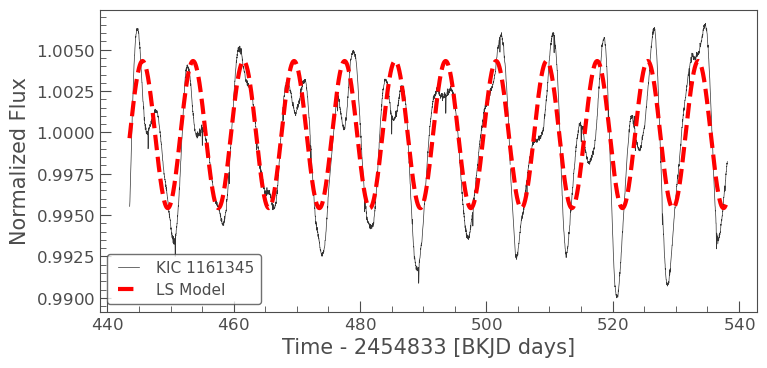

In [10]:
# Create a model light curve for the highest peak in the periodogram.
lc5_model = pg5.model(time=lc5.time, frequency=pg5.frequency_at_max_power)

# Plot the light curve.
ax = lc5.plot()

# Plot the model light curve on top.
lc5_model.plot(ax=ax, lw=3, ls='--', c='red');

The Lomb-Scargle model is more consistent with the phase than the amplitude, but is still a relatively good fit for the rotation signal.

### **Step 8:** Create a TPF with a light curve for each pixel (already improved with a corrector function) and apply a pipeline aperture.

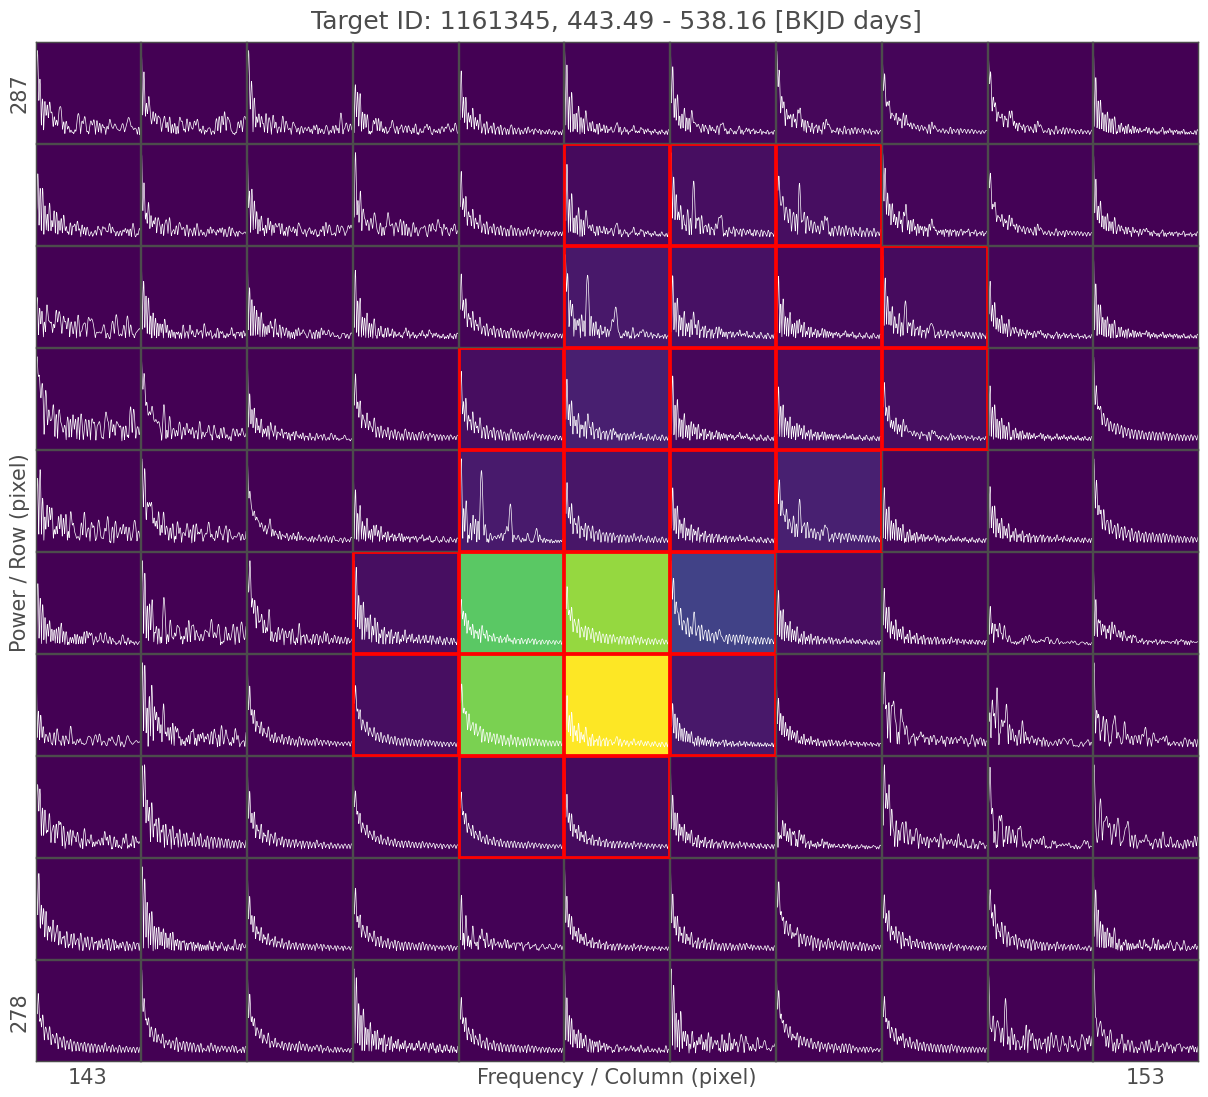

In [12]:
tpf5.plot_pixels(corrector_func=lambda x: x.remove_nans().remove_outliers(), periodogram=True, frequency=f, show_flux=True, aperture_mask='pipeline');

This plot will be included in the final presentation with a side-by-side comparison to the original TPF (without the corrector functions.) The pixels within the pipeline aperture are the ones most likely to be from KOI-984, the target star. Although it is quite small, when zoomed in, most of the pixels outlined in red match the shape of the periodogram above.

### **Step 9:** Create a 2D Lomb-Scargle model and 2D periodogram using Quarter 7 data.

The following code was written by Robby Wilson, a postdoc at NASA GSFC during the time of this presentation.

<ipython-input-13-1f2e7c7bc2a5>:69: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(mean_data.value), origin='lower' , vmax=5, vmin=1 )


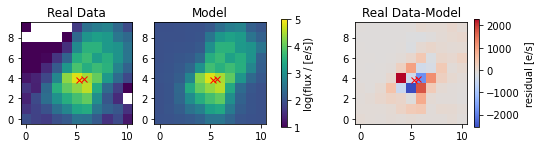

140975.1431138707


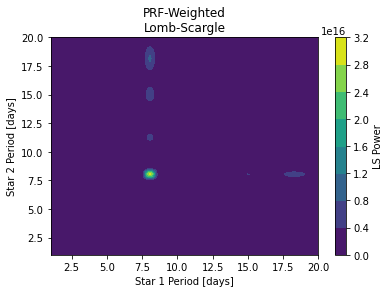

0



1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32



33



34



35



36



37



38



39



40



41



42



43



44



45



46



47



48



49



50



51



52



53



54



55



56



57



58



59



60



61



62



63



64



65



66



67



68



69



70



71



72



73



74



75



76



77



78



79



80



81



82



83



84



85



86



87



88



89



90



91



92



93



94



95



96



97



98



99


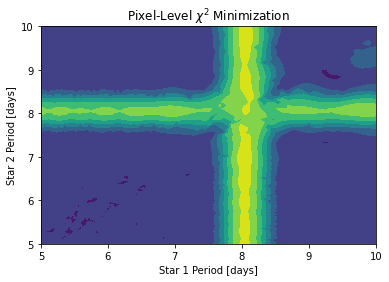

In [13]:
# This cell takes many minutes to run.

for i in [7]:
    tpf = lk.search_targetpixelfile('KIC 1161345', author='Kepler', quarter=i, exptime=1800).download()
    # tpf.interact_sky(magnitude_limit=20)
    star1_coords = SkyCoord('19:24:11.649+36:50:22.98', frame='icrs', unit=(u.hourangle, u.deg), 
                        obstime="J2016.5",)
    star2_coords = SkyCoord('19:24:11.747+36:50:24.29', frame='icrs', unit=(u.hourangle, u.deg), 
                        obstime="J2016.5" )
    
    star1_pix = tpf.wcs.world_to_pixel(star1_coords)
    star2_pix = tpf.wcs.world_to_pixel(star2_coords)
    # print(star1_pix, star2_pix)

    keplerprf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=0, row=0)

    # print(tpf.channel)
    # plt.imshow(np.log10(keplerprf.evaluate(star1_pix[0], star1_pix[1], flux=1e5) ), origin='lower')
    
    # functions

    mean_data = np.median(tpf.flux,axis=0)

    def minimize_tpf_function(x0, data=mean_data):
        model = bothstars_prf_model(x0, star1_coords=star1_pix, star2_coords=star2_pix)   
        return np.sum( (model-data.value)**2.  )


    def bothstars_prf_model(args, star1_coords, star2_coords, flux_ratio=0.9):

        flux_1, bkg, x_offset, y_offset = args

        star1 = keplerprf.evaluate(star1_pix[0]+x_offset, star1_pix[1]+y_offset, flux_1)
        star2 = keplerprf.evaluate(star2_pix[0]+x_offset, star2_pix[1]+y_offset, flux_1*flux_ratio)

        return star1+star2+bkg

    def generate_star_models(star1_coords, star2_coords, col_offset, row_offset):

        star1 = keplerprf.evaluate(star1_coords[0]+row_offset, star1_coords[1]+col_offset, 1.)
        star2 = keplerprf.evaluate(star2_coords[0]+row_offset, star2_coords[1]+col_offset, 1.)

        return star1, star2


    def bothstars_linear_model(args, star1, star2):

        flux1, flux2, bkg = args

        return star1*flux1+star2*flux2+bkg
    
    guess_model = bothstars_prf_model( [1e6, 4, 0.7, 0.5], star1_coords=star1_pix, star2_coords=star2_pix)
    
    result = minimize(minimize_tpf_function, x0=[1e6, 4, 0.5, 0.5], )

    # print(result)
    
    bestfit_bkg = result.x[1]
    bestfit_row_offset = result.x[2]
    bestfit_col_offset = result.x[3]

    # print(bestfit_row_offset, bestfit_col_offset)

    fitmodel = bothstars_prf_model( result.x, star1_coords=star1_pix, star2_coords=star2_pix )

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(8.5,2))

    ax1.imshow(np.log10(mean_data.value), origin='lower' , vmax=5, vmin=1 )
    modplot = ax2.imshow(np.log10(fitmodel), origin='lower', vmax=5, vmin=1)

    resid_plot = ax3.imshow(mean_data.value-fitmodel, origin='lower' , cmap='coolwarm')

    ax1.plot(star1_pix[0], star1_pix[1], 'rx')
    ax1.plot(star2_pix[0], star2_pix[1], 'rx')
    ax2.plot(star1_pix[0], star1_pix[1], 'rx')
    ax2.plot(star2_pix[0], star2_pix[1], 'rx')
    ax3.plot(star1_pix[0], star1_pix[1], 'rx')
    ax3.plot(star2_pix[0], star2_pix[1], 'rx')


    ax1.set_title('Real Data')
    ax2.set_title('Model')
    ax3.set_title('Real Data-Model')
    
    plt.colorbar(resid_plot, ax=ax3, label='residual [e/s]')
    plt.colorbar(modplot, ax=[ax1,ax2], label='log(flux / [e/s])')
    
    plt.show()

#     plt.colorbar(resid_plot, ax=ax3, label='residual [e/s]')
#     plt.colorbar(modplot, ax=[ax1,ax2], label='log(flux / [e/s])')
#     plt.show()


#     plt.figure(figsize=(8,2.5))
#     plt.title('Blended Light Curve from Real Data')
#     plt.plot(times, normalize_lc(lc_from_simdata), '.')
#     plt.xlabel('BKJD')
#     plt.ylabel('Relative Flux')
#     plt.show()

    # more functions
    def normalize_lc(x):
        return x/np.median(x)

    star1_pixel_model, star2_pixel_model = generate_star_models(star1_coords=star1_pix, star2_coords=star2_pix, 
                                                                col_offset=bestfit_col_offset, row_offset=bestfit_row_offset)
    
    def get_timeseries_fluxes(times, tpf_data, star1_prf, star2_prf):
    
        star_prfs = np.array([star1_prf,star2_prf,np.ones_like(star1_prf)])
        ntimes = tpf_data.shape[0]


        X1 = star_prfs[:, np.ones(tpf_data.shape[1:],bool)].T


        weights = []

        # There's definitely a better, more vector-y, way to do this, but I gave up. 
        for i in range(ntimes):

            dat = tpf_data[i].ravel()
            w = np.linalg.solve(X1.T.dot(X1), X1.T.dot(dat))
            weights.append(w)    

        return np.array(weights)
    
    def quick_1d_periodogram(t, flux, freq):
        # subtract median_flux
        med_flux = flux-np.mean(flux)
        return np.abs(np.dot(med_flux, np.exp(-2j * np.pi * freq * t[:, None]))/np.sqrt(len(t)) ) ** 2


    def mad(x):
        return 1.4826 * np.median(np.abs(x-np.median(x)))

    def lomb_scargle_periodogram(tdata, ydata, freq, ):

        # This is not an efficient implementation. Will have to work on that later

        t_i, _ = np.meshgrid(tdata, freq*2*np.pi)
        y_i, omega = np.meshgrid(ydata, freq*2*np.pi)

        y_mean = np.mean(ydata)

        #The algorithm taken from Leroy+2012 and Press+1992. 
        Sy = np.sum( (y_i-y_mean)*np.sin(omega * t_i), axis=1 )
        S2 = np.sum(np.sin(2.*omega * t_i) , axis=1)
        Cy = np.sum( (y_i-y_mean) * np.cos(omega*t_i) , axis=1)
        C2 = np.sum(np.sin(2.*omega * t_i) , axis=1)

        tau = (1./(2.*omega[:,0])) * np.arctan(S2/C2)

        cos_tau = np.cos(tau*omega[:,0] )
        cos_2tau = np.cos(2*tau*omega[:,0])
        sin_tau = np.cos(tau*omega[:,0])
        sin_2tau = np.cos(2*tau*omega[:,0])

        y_cos_term = Cy*cos_tau + Sy*sin_tau
        y_sin_term = Sy*cos_tau - Cy*sin_tau
        cos_2_term = 0.5* (len(t_i) + C2 * cos_2tau + S2 * sin_2tau)
        sin_2_term = 0.5* (len(t_i) + S2 * cos_2tau - C2 * sin_2tau)

        return y_cos_term**2./cos_2_term + y_sin_term**2./sin_2_term

    def get_mean_star_fluxes(times, tpf_data, star1_prf, star2_prf):

        star_prfs = np.array([star1_prf,star2_prf,np.ones_like(star1_prf)])
        ntimes = tpf_data.shape[0]


        X1 = star_prfs[:, np.ones(tpf_data.shape[1:],bool)].T
        X2 = np.hstack([np.vstack([X1] * ntimes)])

        #print(X2.shape,tpf_data.astype(float).ravel().shape )

        w = np.linalg.solve(X2.T.dot(X2), X2.T.dot(tpf_data.astype(float).ravel()))

        return w

    def sine_prf_func(P, amp, phase,  time, star_prf ):

        return star_prf*amp*np.sin(2*np.pi/P*time+phase)

    def fit_spatially_resolved_sinusoids(time, tpf_mean_resids, star1_prf, star2_prf, P1, P2):

        # format time and stuff before 

        min_func = lambda x: np.sum( (tpf_mean_resids - ( sine_prf_func(P1,x[0],x[1],time,star1_prf)+  sine_prf_func(P2,x[2],x[3],time,star2_prf) ) )**2. )

        result = minimize(min_func, x0=[1e3,0.,1e3,0.], method='L-BFGS-B',)

        return result 

    def get_2d_spatial_periodogram_thing(tpf_data, star1_prf, star2_prf, t, freq, npoints_per_bin=5):

        star_prfs = np.array([star1_prf,star2_prf,np.ones_like(star1_prf)])
        ntimes = tpf_data.shape[0]

        star1_flux, star2_flux, bkg_flux = get_mean_star_fluxes(times=times, 
                              tpf_data=tpf_data, 
                              star1_prf=star1_prf, 
                              star2_prf=star2_prf)

        mean_model = np.array( [(star1_prf*star1_flux + star2_prf*star2_flux + bkg_flux)]*len(t) )

        #print(mean_model.shape)

        mean_resids = mean_model - tpf_data
        mean_resids_binned = np.array([np.mean(mean_resids[i:i+npoints_per_bin], axis=0) for i in range(0,len(t),npoints_per_bin)])

        tpf_data_binned = np.array([np.mean(tpf_data[i:i+npoints_per_bin], axis=0) for i in range(0,len(t),npoints_per_bin)])

        time_binned = np.array([np.mean(t[i:i+npoints_per_bin]) for i in range(0,len(t),npoints_per_bin)])
        time_reshaped = time_binned[:, None, None]


        star1_prf_reshaped = np.array([star1_prf]*len(time_reshaped))
        star2_prf_reshaped = np.array([star2_prf]*len(time_reshaped))

        chi2_values = []
        i=0

        mean_chi2 = np.sum(mean_resids_binned**2.)

        for f1 in freq:
            print(i)
            i+=1
            for f2 in tqdm(freq):
                out = fit_spatially_resolved_sinusoids(time_reshaped, mean_resids_binned, 
                                              star1_prf_reshaped, star2_prf_reshaped, P1=1./f1, P2=1./f2)
                chi2_values.append(out.fun)

        return np.array(chi2_values).reshape(len(freq), len(freq)) - mean_chi2

    def prf_weighted_2d_lombscargle(t, tpf_data, star1_prf, star2_prf, freq, ):

        star_prfs = np.array([star1_prf,star2_prf,np.ones_like(star1_prf)])
        ntimes = tpf_data.shape[0]

        star1_flux, star2_flux, bkg_flux = get_mean_star_fluxes(times=times, 
                              tpf_data=tpf_data, 
                              star1_prf=star1_prf, 
                              star2_prf=star2_prf)
        
        print(star1_flux)

        mean_model = np.array( [(star1_prf*star1_flux + star2_prf*star2_flux + bkg_flux)]*len(t) )

        star1_resids = np.nansum( ((tpf_data-mean_model)*star1_prf).T.reshape(-1, mean_model.shape[0]), axis=0) 
        star2_resids = np.nansum( ((tpf_data-mean_model)*star2_prf).T.reshape(-1, mean_model.shape[0]), axis=0) 

        #print(star1_resids.shape, mean_model.shape)


        # There's definitely a better, more vector-y, way to do this, but I gave up. 
        star1_weighted_ls = lomb_scargle_periodogram(tdata=t, ydata=star1_resids, freq=freq, )
        star2_weighted_ls = lomb_scargle_periodogram(tdata=t, ydata=star2_resids, freq=freq, )

        star1_ls_grid, star2_ls_grid = np.meshgrid(star1_weighted_ls,star2_weighted_ls)

        return star1_ls_grid * star2_ls_grid
   
    
    # back to data
    times = tpf.time.bkjd
    lomb_scargle_freqs = np.linspace(1./20., 1/1,  10000) 
    
    #phase1 = 6.1
    #phase2 = 3.3
    
    #P1 = 7.75 
    #P2 = 8.8
    
    ls_2d_real = prf_weighted_2d_lombscargle(t=times, tpf_data=tpf.flux.value, star1_prf=star1_pixel_model, 
                                    star2_prf=star2_pixel_model, freq=lomb_scargle_freqs, )
    
    ls_2d_real[np.isnan(ls_2d_real)]=0
    plt.contourf(1./lomb_scargle_freqs, 1./lomb_scargle_freqs, ls_2d_real)
    

    plt.colorbar(label='LS Power')

    plt.title('PRF-Weighted\nLomb-Scargle')
    plt.xlabel('Star 1 Period [days]')
    plt.ylabel('Star 2 Period [days]')
    
    plt.show()
    
    
    delta_chi2_freqs = np.linspace(1./5, 1./10., 100)  
    delta_chi2_test = get_2d_spatial_periodogram_thing(tpf.flux.value, star1_pixel_model, star2_pixel_model, times, delta_chi2_freqs)
    
    plt.contourf(1./delta_chi2_freqs, 1./delta_chi2_freqs, -1*delta_chi2_test)
    plt.xlabel('Star 1 Period [days]')
    plt.ylabel('Star 2 Period [days]')
    plt.title('Pixel-Level $\chi^2$ Minimization')
    
    plt.show()

This concludes the notebook used to create the plots presented during the Code 600 intern final presentations on-site at NASA GSFC. Thank you!